In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'\\CHCFPP01\Guest\MRajabi\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
print(strftime("%Y-%m-%d %H:%M:%S"))

2019-02-07 10:00:24


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2005,2017)
MaxOpenProcesses = 15

Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool'
Project_GDB  = Project_DIR + '\\2.Project_GDB.gdb'
ContractsDir = Project_DIR + '\\4.Contracts_AnalysisFiles'
DocumentsDir = Project_DIR + '\\5.Documents'
PythonDir    = Project_DIR + '\\6.Python_Codes'
ReceivedDir  = Project_DIR + '\\7.ReceivedData'
XML_Dir      = ReceivedDir + '\\HSIP Candidate Applications'


# IRIS Dataset
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\5.0_Roadway_Layer\IRIS'
IRISPath = r'C:\Users\mr068144\Downloads\IL Data\IRIS\IL_IRIS.gdb'
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment\CrashData_Cleaned\IL_SafetyDB.gdb'
IRISPath = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\7_BaseData\Master_BaseFiles_Data\9.0_IL_SafetyDB\IL_SafetyDB.gdb'
IRIS_Route = {y:os.path.join(IRISPath,'Route_{}'.format(y)) for y in Years}
IRIS_Tab   = {y:os.path.join(IRISPath,'Att_{}'.format(y)) for y in Years}
IRIS_Tab[2012] = IRIS_Tab[2013]
IRIS_Cleaned = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment\IRIS_Cleaned\IRIS_05_17.csv'

# Intersections Dataset
IntPG = r'C:\Users\mr068144\Downloads\IL Data\6.0_Intersection_Layer\IRIS_Ints.gdb\Int2014_PG'
IntPG = IRISPath + '\\Intersection2014_361999_CleanedUpFall2018'
Intersections = {year:IntPG for year in Years}

#Crash Dataset
CrashData  = {y:os.path.abspath(r'C:\Users\mr068144\Downloads\IL Data\IL Crash Data\IL_Crash.gdb\\' +
                          'CrashExtract_' + str(y) + '_GIS') for y in Years}
Crash_Cleaned = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment\CrashData_Cleaned\Crash_05_16.csv'

Fields = ['AADT',
          'O_SHD1_TYP','O_SHD1_WTH','O_SHD2_TYP','O_SHD2_WTH',
          'I_SHD1_TYP','I_SHD1_WTH','I_SHD2_TYP','I_SHD2_WTH',
          'LANES','LN_WTH','MED_TYP','MED_WTH','SURF_WTH','URBAN','PG']
#Fields = ['AADT','URBAN','PG']
RouteID = 'INVENTORY'
BMP = 'BEG_STA'
EMP = 'END_STA'

# Geocoded projects
Const_Int  = Project_GDB + '\\Const_Int_All'
Const_Seg  = Project_GDB + '\\Const_Seg_All'

HSIP_Path    = ReceivedDir + '\\HSIP_AllApprovedProjects.xlsm'
WPPS_Ob_Path = ReceivedDir + '\\HSIP Contract and Obligation Data.xlsx'
WPPS_Pr_Path = ReceivedDir + '\\HSIP Project Programmed Data.xlsx'
SPF_Data     = ReceivedDir  + '\\SPF Coefficients.xlsx'

2019-01-28 14:13:00


In [18]:
# Reading Contracts Info
print(strftime("%Y-%m-%d %H:%M:%S"))
#Cont_DF = pd.concat([hsmpy3.common.FCtoDF(fc,readGeometry=True) for fc in [HSIP_Int,HSIP_Seg]])
Cont_DF = pd.read_excel(DocumentsDir + '\\Cont_DF.xlsx',index_col=0)
HSIP_DF = pd.read_excel(DocumentsDir + '\\HSIP_DF.xlsx')
HSIP_DF = HSIP_DF.reindex(sorted(HSIP_DF.columns), axis=1)
HSIP_Joined = pd.read_excel(DocumentsDir + '\\HSIP_Joined.xlsx')
HSIP_Joined.index = HSIP_Joined.HSIPID
HSIP_DF.index = HSIP_DF['HSIP ID']
for f in ['Problem Description','Location Description','Approved Scope']:
    HSIP_Joined[f] = HSIP_DF[f].loc[HSIP_Joined.index]
Pay_DF = pd.read_csv(ReceivedDir + '\\Contract_PayItems.csv')
Pay_DF.index = pd.MultiIndex.from_arrays([Pay_DF.ContNum,Pay_DF.PayItem])

Seg_DF1 = hsmpy3.common.FCtoDF(Const_Seg,readGeometry=True)
Int_DF1 = hsmpy3.common.FCtoDF(Const_Int,readGeometry=True)
def GetPLsCentroid(L):
    prts = []
    for p in L:
        for pr in p:
            prts.append(pr)
    g = arcpy.Geometry('LINE',arcpy.Array(prts),hsmpy3.common.NAD1983IL)
    p = arcpy.Geometry('POINT',g.centroid,hsmpy3.common.NAD1983IL)
    p = p.projectAs(hsmpy3.common.WGS1984)
    return('{},{}'.format(p.firstPoint.Y,p.firstPoint.X))
def GetPNsCentroid(L):
    pnts = []
    for p in L:
        pnts.append(p[0])
    g = arcpy.Geometry('multipoint',arcpy.Array(pnts),hsmpy3.common.NAD1983IL)
    p = arcpy.Geometry('POINT',g.centroid,hsmpy3.common.NAD1983IL)
    p = p.projectAs(hsmpy3.common.WGS1984)
    return('{},{}'.format(p.firstPoint.Y,p.firstPoint.X))
s1 = Seg_DF1.groupby('ContNum')['Shape'].aggregate(GetPLsCentroid)
s2 = Int_DF1.groupby('ContNum')['Shape'].aggregate(GetPNsCentroid)
s = pd.DataFrame(pd.concat([s1,s2]))
s['ContNum'] = s.index
df = pd.DataFrame(s.groupby('ContNum')['Shape'].agg({'Shape':'first'}))
df['Link'] = df.Shape.apply(lambda x:'https://www.google.com/maps?q=loc:{}&t=k'.format(x))
Cont_DF['Link'] = df.Link.loc[Cont_DF.index]

df = pd.DataFrame(Pay_DF.groupby('ContNum')['COMPLETED_AMT'].aggregate(sum))
idx = Cont_DF[Cont_DF.CompletionAmount==0].index
Cont_DF.CompletionAmount.loc[idx] = df.COMPLETED_AMT.loc[idx].fillna(0)

2019-01-29 08:16:05


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:11: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  # This is added back by InteractiveShellApp.init_path()
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:38: FutureWarning: 'ContNum' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:38: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:40: FutureWarning: 
Passing list-likes to .loc or [] with a

In [8]:
print('[{}] read crash data'.format(strftime("%Y-%m-%d %H:%M:%S")))
Crash_DF  = pd.read_csv(Crash_Cleaned)
Crash_DF = Crash_DF[(~pd.isnull(Crash_DF.INVENTORY)) & (~pd.isnull(Crash_DF.MP))]
Crash_DF.DATE = pd.to_datetime(Crash_DF.DATE)
print('[{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),Crash_DF.shape))
print('[{}]  - indexing'.format(strftime("%Y-%m-%d %H:%M:%S")))
#Crash_DF.index = pd.MultiIndex.from_arrays([Crash_DF.INVENTORY,Crash_DF.MP,Crash_DF.DATE],names=['INVENTORY','Milepost','Time'])
Crash_DF.index = Crash_DF.CID
print('[{}]  - sorting'.format(strftime("%Y-%m-%d %H:%M:%S")))
Crash_DF = Crash_DF.sort_index()
print('[{}] done.'.format(strftime("%Y-%m-%d %H:%M:%S")))

[2019-01-28 15:13:41] read crash data
[2019-01-28 15:15:44]  - (3821046, 57)
[2019-01-28 15:15:44]  - indexing
[2019-01-28 15:15:44]  - sorting
[2019-01-28 15:15:45] done.


In [5]:
fc = r"C:\Users\mr068144\Documents\ArcGIS\Projects\HSIP Evaluation\HSIP Evaluation.gdb\Crashes_05_16_Sort"
uc = arcpy.UpdateCursor(fc)
for row in uc:
    y = row.getValue('Date').year
    row.setValue('Year',y)
    uc.updateRow(row)
del uc
del row

In [9]:
print('[{}] read roadway data'.format(strftime("%Y-%m-%d %H:%M:%S")))
IRIS_DF = pd.read_csv(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment\IRIS_Cleaned\IRIS_05_17.csv')
IRIS_DF.index = pd.MultiIndex.from_arrays(arrays=[IRIS_DF.INVENTORY,IRIS_DF.YEAR,IRIS_DF.BMP,IRIS_DF.EMP])
print('[{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),IRIS_DF.shape))

[2019-01-28 15:15:45] read roadway data


C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (5,8,11,12,13,14,15,35,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[2019-01-28 15:17:22]  - (5964369, 53)


In [4]:
# Add Site ID to Int
print('[{}] add site ID to contract locations'.format(strftime("%Y-%m-%d %H:%M:%S")))
Int_DF1['SiteID'] = Int_DF1.groupby('ContNum').cumcount()+1
Int_DF1['SiteID']  = Int_DF1.apply(lambda x:'{}_I_{}'.format(x.ContNum,x.SiteID), axis=1)
Int_DF1 = Int_DF1.sort_index()
arcpy.AddField_management(Const_Int,'SiteID','TEXT')
uc = arcpy.UpdateCursor(Const_Int)
for r in uc:
    c = r.getValue('OBJECTID')
    r.setValue('SiteID',str(Int_DF1.loc[c,'SiteID']))
    uc.updateRow(r)
del uc, r
print('[{}] - intersections - done.'.format(strftime("%Y-%m-%d %H:%M:%S")))

Seg_DF1 = Seg_DF1.sort_values(['ContNum','I_RID'])
Seg_DF1['SiteID'] = Seg_DF1.groupby('ContNum').cumcount()+1
Seg_DF1['SiteID']  = Seg_DF1.apply(lambda x:'{}_S_{}'.format(x.ContNum,x.SiteID), axis=1)
Seg_DF1 = Seg_DF1.sort_index()
arcpy.AddField_management(Const_Seg,'SiteID','TEXT')
uc = arcpy.UpdateCursor(Const_Seg)
for r in uc:
    c = r.getValue('OBJECTID')
    r.setValue('SiteID',str(Seg_DF1.loc[c,'SiteID']))
    uc.updateRow(r)
del uc, r
print('[{}] - segments - done.'.format(strftime("%Y-%m-%d %H:%M:%S")))

[2019-01-23 11:44:53] add site ID to contract locations
[2019-01-23 11:44:58] - intersections - done.
[2019-01-23 11:45:03] - segments - done.


In [8]:
# Import Roadway Data: Geocoded Loc -> Segments with Attributes
for year in range(2015,2017):
    hsmpy3.network.ImportRoadwayData(
        Input=Const_Seg,
        AttTable=IRIS_Tab[year],
        Route=IRIS_Route[year],
        BMP='BMP',
        RouteID='RID',
        EMP='EMP',
        Fields=Fields,
        RouteID_I='I_RID',
        Output=Project_GDB + '\\Seg_Att_{}'.format(year),
        XY_Tolerance = "60 Feet"
    )
    df = hsmpy3.common.FCtoDF(Project_GDB + '\\Seg_Att_{}'.format(year))
    df['YEAR'] = year
    Seg_DF = pd.concat([Seg_DF,df],sort=False)
    print('[{}][{}] {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year,arcpy.management.GetCount(Project_GDB + '\\Seg_Att_{}'.format(year))[0]))

[2019-01-23 13:16:50][2015] 7161
[2019-01-23 13:26:06][2016] 7162
<class 'pandas.core.frame.DataFrame'>
Int64Index: 14323 entries, 1 to 7162
Data columns (total 25 columns):
INVENTORY       14323 non-null object
BMP             14323 non-null float64
EMP             14323 non-null float64
URBAN           14323 non-null object
PG              14323 non-null object
AADT            14007 non-null float64
LANES           14323 non-null int64
LN_WTH          14168 non-null float64
MED_TYP         14323 non-null int64
MED_WTH         4492 non-null float64
O_SHD1_TYP      14323 non-null int64
O_SHD1_WTH      14258 non-null float64
O_SHD2_TYP      14323 non-null int64
O_SHD2_WTH      5118 non-null float64
I_SHD1_TYP      14323 non-null int64
I_SHD1_WTH      4320 non-null float64
I_SHD2_TYP      14323 non-null int64
I_SHD2_WTH      1386 non-null float64
SURF_WTH        14323 non-null int64
I_RID           14323 non-null object
ContNum         14323 non-null object
SiteID          14323 non-null

In [11]:
# Import Roadway Data: Geocoded Loc -> Segments with Attributes
Seg_DF = pd.DataFrame()
for year in range(2005,2017):
    df = hsmpy3.common.FCtoDF(Project_GDB + '\\Seg_Att_{}'.format(year))
    df['YEAR'] = year
    Seg_DF = pd.concat([Seg_DF,df],sort=False)
    print('[{}][{}] {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year,arcpy.management.GetCount(Project_GDB + '\\Seg_Att_{}'.format(year))[0]))

[2019-01-29 07:52:58][2005] 6672
[2019-01-29 08:04:43][2006] 6780
[2019-01-29 08:05:08][2007] 6990
[2019-01-29 08:05:30][2008] 7146
[2019-01-29 08:05:53][2009] 7217
[2019-01-29 08:06:15][2010] 7069
[2019-01-29 08:06:36][2011] 6963
[2019-01-29 08:06:57][2012] 6912
[2019-01-29 08:07:18][2013] 6976
[2019-01-29 08:07:40][2014] 7109
[2019-01-29 08:08:01][2015] 7161
[2019-01-29 08:08:22][2016] 7162


In [11]:
# Import Int Data 1/2: Geocoded Locations -> Segments by Year -Just BMP, EMP, Year here
Int_DF = pd.DataFrame()
for year in range(2005,2017):
    Buffer = "80 Feet"
    Tolerance = "10 Feet"
    RouteID = 'RID'
    #print('[{}][{}] Intersect'.format(strftime("%Y-%m-%d %H:%M:%S"),year))
    
    Output = Project_GDB + '\\Out_Int_{}'.format(year)
    Intersections = Const_Int
    TrafficControl = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\IL_Crash_Assignment\CrashData_Cleaned\IL_SafetyDB.gdb\\Int_Points'
    Int = hsmpy3.common.CreateOutPath(MainFile=Output,appendix='Int',Extension='')
    arcpy.Intersect_analysis(
        in_features = IRIS_Route[year],
        out_feature_class = Int, 
        join_attributes = "ALL", 
        cluster_tolerance = "-1 Unknown", 
        output_type = "POINT")
    #print('[{}][{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year))

    #print('[{}] {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year))
    SPJ = hsmpy3.common.CreateOutPath(MainFile=Output,appendix='SPJ',Extension='')
    arcpy.SpatialJoin_analysis(
        target_features = Int, 
        join_features = Intersections, 
        out_feature_class = SPJ, 
        join_operation = "JOIN_ONE_TO_ONE", 
        join_type = "KEEP_COMMON", 
        match_option = "CLOSEST", 
        search_radius = Buffer, 
        distance_field_name = "")

    arcpy.DeleteIdentical_management(
        in_dataset = SPJ, 
        fields = arcpy.Describe(SPJ).ShapeFieldName, 
        xy_tolerance = "", 
        z_tolerance = "0")

    OrgFields = [f.name for f in arcpy.ListFields(Intersections)]
    arcpy.DeleteField_management(SPJ,[f.name for f in arcpy.ListFields(SPJ) if not f.required and not f.name in OrgFields])
    #print('[{}] {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year))
    
    arcpy.management.Delete(Output)
    arcpy.SpatialJoin_analysis(
        target_features = SPJ, 
        join_features = TrafficControl, 
        out_feature_class = Output, 
        join_operation = "JOIN_ONE_TO_ONE", 
        join_type = "KEEP_COMMON", 
        match_option = "CLOSEST", 
        search_radius = Buffer, 
        distance_field_name = "")

    OrgFields.extend(['TCON_TYP','LEG_COUNT'])
    arcpy.DeleteField_management(Output,[f.name for f in arcpy.ListFields(Output) if not f.required and not f.name in OrgFields])

    EventTable = hsmpy3.common.CreateOutPath(MainFile=Output,appendix='EventTable',Extension='')
    arcpy.LocateFeaturesAlongRoutes_lr(
        in_features                = Output, 
        in_routes                = IRIS_Route[year], 
        route_id_field            = RouteID, 
        radius_or_tolerance        = Tolerance, 
        out_table                = EventTable, 
        out_event_properties    = " ".join([RouteID, "POINT", "MP"]),
        route_locations            = "ALL", 
        in_fields                = "FIELDS", 
        m_direction_offsetting    = "M_DIRECTON"
        )
    arcpy.AddField_management(EventTable,'FirstMP','DOUBLE')
    arcpy.AddField_management(EventTable,'LastMP' ,'DOUBLE')
    # Milepost Correction
    EMPDict = {r.getValue(RouteID):[r.getValue('Shape').firstPoint.M,r.getValue('Shape').lastPoint.M] for r in arcpy.SearchCursor(IRIS_Route[year])}
    r = 0 
    uc = arcpy.UpdateCursor(EventTable)
    for r in uc:
        inv = r.getValue(RouteID)
        r.setValue('FirstMP',EMPDict[inv][0])
        r.setValue('LastMP',EMPDict[inv][1])
        uc.updateRow(r)
    del uc, r
    df = hsmpy3.common.FCtoDF(EventTable)
    df = df.sort_values('SiteID')
    df['MP'] = df.apply(lambda row:row['FirstMP'] if row['MP']<row['FirstMP'] else row['MP'],axis=1)
    df['MP'] = df.apply(lambda row:row['LastMP']  if row['MP']>row['LastMP'] else row['MP'],axis=1)
    df['BMP'] = df.apply(lambda row:max(row['MP']-250.0/5280.0,row['FirstMP']),axis=1)
    df['EMP'] = df.apply(lambda row:min(row['MP']+250.0/5280.0,row['LastMP']),axis=1)
    df['YEAR'] = year
    df = df[['RID','BMP','EMP','YEAR','ContNum','MP', 'SiteID', 'LEG_COUNT', 'TCON_TYP']]
    
    Output = Project_GDB + '\\Int_App_{}'.format(year)
    arcpy.management.Delete(Output)
    arcpy.management.CreateTable(out_name = os.path.basename(Output),
                                        out_path = os.path.dirname(Output))
    arcpy.AddField_management(Output,'RID','Text')
    arcpy.AddField_management(Output,'BMP','Double')
    arcpy.AddField_management(Output,'EMP','Double')
    arcpy.AddField_management(Output,'MP','Double')
    arcpy.AddField_management(Output,'ContNum','TEXT')
    arcpy.AddField_management(Output,'SiteID','TEXT')
    arcpy.AddField_management(Output,'LEG_COUNT','Short')
    arcpy.AddField_management(Output,'TCON_TYP','Short')
    ic = arcpy.InsertCursor(Output)
    for i,r in df.iterrows():
                row = ic.newRow()
                row.setValue('RID',str(i))
                row.setValue('BMP',float(r.BMP))
                row.setValue('EMP',float(r.EMP))
                row.setValue('MP',float(r.MP))
                row.setValue('ContNum',str(r.ContNum))
                row.setValue('SiteID',str(r.SiteID))
                row.setValue('LEG_COUNT',int(r.LEG_COUNT))
                row.setValue('TCON_TYP',int(r.TCON_TYP))
                ic.insertRow(row)
    del ic
    del row
    Int_DF = pd.concat([Int_DF,df],sort=False)
    print('[{}][{}] - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),year,str(arcpy.management.GetCount(Output))))
Int_DF.groupby(['SiteID'])['LEG_COUNT','TCON_TYP'].aggregate('first').to_csv('Cont_Int_Data.csv')

[2019-01-28 08:28:51] - 856
[2019-01-28 08:33:56] - 881
[2019-01-28 08:39:23] - 933
[2019-01-28 08:45:44] - 987
[2019-01-28 08:53:13] - 1079
[2019-01-28 09:02:32] - 1109
[2019-01-28 09:14:02] - 1154
[2019-01-28 09:26:04] - 1189
[2019-01-28 09:38:50] - 1178
[2019-01-28 09:50:48] - 1209
[2019-01-28 10:03:02] - 1210
[2019-01-28 10:15:52] - 1217


In [12]:
# Import Int Data 2/2: Add IRIS Attributes
# Indexing IRIS
print('[{}] overlay with iris'.format(strftime("%Y-%m-%d %H:%M:%S")))
idx1 = pd.Index(IRIS_DF.INVENTORY)
idx2 = pd.Index(IRIS_DF.YEAR)
idx3 = pd.IntervalIndex.from_tuples([(bmp,emp) for bmp,emp in zip(IRIS_DF.BMP,IRIS_DF.EMP)],'left')
IRIS_DF.index = pd.MultiIndex.from_arrays([idx1,idx2,idx3],names = ['Route ID','Time','Milepost'])

def QueryIRIS(IRIS_DF,inv,bmp,emp,Years,Fields):
    idf = pd.DataFrame()
    Int = pd.IntervalIndex.from_arrays(left=[bmp],right=[emp],closed='left')
    df = IRIS_DF.loc[inv]
    L = []
    for year in Years:
        ydf = df.loc[year]
        ydf.index = pd.IntervalIndex.from_arrays(left=ydf.BMP,right=ydf.EMP,closed='left')
        ydf = ydf.loc[Int,Fields]
        ydf['RID'] = inv
        ydf['BMP'] = [i.left for i in ydf.index]
        ydf['EMP'] = [i.right for i in ydf.index]
        ydf['YEAR'] = year
        ydf.loc[ydf.BMP<bmp,'BMP'] = bmp
        ydf.loc[ydf.EMP>emp,'EMP'] = emp
        L.append(ydf)
    df = pd.concat(L)
    df = df.reset_index(drop=True)
    return(df)
L = []
for i,row in Int_DF.iterrows():
    df = QueryIRIS(IRIS_DF,row.RID,row.BMP,row.EMP,[row.YEAR],Fields)
    df['ContNum'] = row.ContNum
    df['SiteID'] = row.SiteID
    df['MP'] = row.MP
    df['LEG_COUNT'] = row.LEG_COUNT
    df['TCON_TYP'] = row.TCON_TYP
    L.append(df)
df = pd.concat(L)
idx1 = pd.Index(df.RID)
idx2 = pd.Index(df.YEAR)
idx3 = pd.IntervalIndex.from_tuples([(bmp,emp) for bmp,emp in zip(df.BMP,df.EMP)],'left')
df.index = pd.MultiIndex.from_arrays([idx1,idx2,idx3],names = ['Route ID','Time','Milepost'])
Int_App_DF = df.sort_index()
Int_App_DF = Int_App_DF.rename(columns={'RID':'INVENTORY'})
print('[{}] done'.format(strftime("%Y-%m-%d %H:%M:%S")))

[2019-01-28 10:21:15] overlay with iris
[2019-01-28 10:26:51] done


In [10]:
print('[{}] read contracts data'.format(strftime("%Y-%m-%d %H:%M:%S")))
Loc_DF = pd.concat([Seg_DF,Int_App_DF],sort=False)
Loc_DF = Loc_DF.drop(['LOC_ERROR','Shape_Length'],axis=1)
Loc_DF = Loc_DF.rename(columns={'BMP':'BEG_STA','EMP':'END_STA'})
idx1 = pd.Index(Loc_DF.INVENTORY)
idx2 = pd.IntervalIndex.from_tuples([(bmp,emp) for bmp,emp in zip(Loc_DF.BEG_STA,Loc_DF.END_STA)],'left')
idx3 = pd.IntervalIndex.from_tuples([(pd.Timestamp(y,1,1),pd.Timestamp(y+1,1,1)) for y in Loc_DF.YEAR],'left')
#Loc_DF.index = pd.MultiIndex.from_arrays([idx1,idx2,idx3],names = ['INVENTORY','Milepost','Dates'])
Loc_DF.index = pd.MultiIndex.from_arrays([Loc_DF.INVENTORY,idx2,Loc_DF.YEAR],names = ['INVENTORY','Milepost','Year'])
Loc_DF = Loc_DF.sort_index()
print('[{}]  - {}'.format(strftime("%Y-%m-%d %H:%M:%S"),Loc_DF.shape))

print('[{}] appending crash data'.format(strftime("%Y-%m-%d %H:%M:%S")))
def GetPeriod(year,BP,CP,AP):
    if year in list(pd.Series(BP.split(';')).astype(int)):
        return('Before')
    if year in list(pd.Series(CP.split(';')).astype(int)):
        return('Construction')
    if year in list(pd.Series(AP.split(';')).astype(int)):
        return('After')
Loc_DF['Period'] = [GetPeriod(y,bp,cp,ap) for y,bp,cp,ap in zip(Loc_DF.YEAR,
                                                                Cont_DF.BeforePeriod.loc[Loc_DF.ContNum],
                                                                Cont_DF.ConstPeriod.loc[Loc_DF.ContNum],
                                                                Cont_DF.AfterPeriod.loc[Loc_DF.ContNum])]
Crash_DF.index = pd.MultiIndex.from_arrays([Crash_DF.INVENTORY,Crash_DF.MP,Crash_DF.DATE],names=['INVENTORY','Milepost','Time'])
CID = []
for i in range(0,Loc_DF.shape[0]):
    idx = list(Loc_DF.iloc[[i]].index)[0]
    inv,mp,ts = idx
    #print(inv,mp,ts)
    try:
        df = Crash_DF.loc[inv]
        CID.append(list(df[(df.MP.between(mp.left,mp.right)) & (df.DATE.between(datetime(ts,1,1),datetime(ts+1,1,1)))]['CID']))
    except:
        CID.append([])
Loc_DF['CID'] = pd.Series(CID,index = Loc_DF.index)
print('[{}] done.'.format(strftime("%Y-%m-%d %H:%M:%S")))
Loc_DF.CID = Loc_DF.CID.apply(lambda x:';'.join([str(i) for i in x]))
Loc_DF.to_csv('Contracts_IRIS_Crashes.csv',index=False)

[2019-01-28 15:17:22] read contracts data


NameError: name 'Seg_DF' is not defined

In [3]:
# Read the results of Contract locations
Loc_DF = pd.read_csv('Contracts_IRIS_Crashes.csv')
idx1 = pd.Index(Loc_DF.INVENTORY)
idx2 = pd.IntervalIndex.from_tuples([(bmp,emp) for bmp,emp in zip(Loc_DF.BEG_STA,Loc_DF.END_STA)],'left')
#idx3 = pd.IntervalIndex.from_tuples([(pd.Timestamp(y,1,1),pd.Timestamp(y+1,1,1)) for y in Loc_DF.YEAR],'left')
#Loc_DF.index = pd.MultiIndex.from_arrays([idx1,idx2,idx3],names = ['INVENTORY','Milepost','Dates'])
Loc_DF.index = pd.MultiIndex.from_arrays([Loc_DF.INVENTORY,idx2,Loc_DF.YEAR],names = ['INVENTORY','Milepost','Year'])
Loc_DF = Loc_DF.sort_index()
Loc_DF.CID = Loc_DF.CID.fillna('')
Loc_DF.CID = Loc_DF.CID.apply(lambda x:[int(i) for i in x.split(';') if len(i)>0])
Loc_DF

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


RID  \
INVENTORY         Milepost                               Year                      
001  01040 003345 [0.9426515151567538, 0.99)             2011                NaN   
                                                         2012                NaN   
                                                         2013                NaN   
                                                         2014                NaN   
                                                         2015                NaN   
                                                         2016                NaN   
001  20063 000000 [5.852651515145695, 5.89)              2005                NaN   
                                                         2006                NaN   
                                                         2007                NaN   
                  [5.89, 5.9)                            2005                NaN   
                                                         2006                NaN   
                                                         2007                NaN   
                  [5.9, 5.947348484842664)               2005                NaN   
                                                         2006                NaN   
                                                         2007                NaN   
                  [5.9526515151515165, 5.96)             2014                NaN   
                                                         2015                NaN   
                                                         2016                NaN   
                  [5.9526515151515165, 5.99)             2008                NaN   
                                                         2009                NaN   
                                                         2010                NaN   
                                                         2011                NaN   
                                                         2012                NaN   
                                                         2013                NaN   
                  [5.96, 5.99)                           2014                NaN   
                                                         2015                NaN   
                                                         2016                NaN   
                  [5.99, 6.0)                            2008                NaN   
                                                         2009                NaN   
                                                         2010                NaN   
...                                                                          ...   
NaN               [38.88069999999425, 39.09)             2007  057  10055 000000   
                                                         2008  057  10055 000000   
                                                         2009  057  10055 000000   
                  [38.88090000000375, 39.09)             2010  057  10055 000000   
                  [38.88090000000375, 39.31990000000224) 2011  057  10055 000000   
                                                         2012  057  10055 000000   
                                                         2013  057  10055 000000   
                                                         2014  057  10055 000000   
                                                         2015  057  10055 000000   
                                                         2016  057  10055 000000   
                  [38.89560000000347, 39.09)             2005  057  10055 000000   
                                                         2006  057  10055 000000   
                  [39.09, 39.31350000000384)             2005  057  10055 000000   
                                                         2006  057  10055 000000   
                  [39.09, 39.31979999999749)             2007  057  10055 000000   
                                             

In [15]:
def FlattenNestedList(L):
    out = []
    try:
        for l in L:
            out.extend(l)
    except:
        pass
    return(out)
df1 = pd.DataFrame(index=pd.MultiIndex.from_product([pd.Index(list(set(Loc_DF.ContNum))),
                                      pd.Index(range(2005,2017))],names=['ContNum','Year']),
                  columns=['Period','K','A','B','C','O','CIDs','KABCO','ContNum','YEAR'])
df1.ContNum = df1.index.to_series().apply(lambda x:x[0])
df1.CIDs = Loc_DF.groupby(['ContNum','YEAR'])['CID'].aggregate(list).loc[df1.index].apply(FlattenNestedList)
s = df1.groupby(['ContNum'])['CIDs'].apply(FlattenNestedList)
L = []
for c in s.index:
    for cid in s.loc[c]:
        L.append((c,cid))
idx = pd.MultiIndex.from_tuples(L)
df1 = pd.DataFrame(index=idx,columns=['ContNum','YEAR','Period','CID'])
df1.ContNum = df1.index.to_series().apply(lambda x:x[0])
df1.CID = df1.index.to_series().apply(lambda x:x[1])
df1.YEAR = df1.CID.apply(lambda x:int(str(x)[0:4]))
df1.index = pd.MultiIndex.from_arrays([df1.ContNum,df1.YEAR])
df1.Period = Loc_DF.groupby(['ContNum','YEAR'])['Period'].first().loc[df1.index]
df1.index = pd.Index(df1.CID)
Crash_DF.index = Crash_DF.CID
df1 = pd.concat([df1,Crash_DF.loc[df1.index]],axis=1)
_, i = np.unique(df1.columns, return_index=True)
i.sort()
df1 = df1.iloc[:, i]
df1.index = pd.MultiIndex.from_arrays([df1.ContNum,df1.Period,df1.CID])
df1 = df1.sort_index()
df1.to_csv('Cont_Crashes.csv')
Cont_Crash_DF = df1

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:13: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  del sys.path[0]
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:14: FutureWarning: 'ContNum' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  


In [21]:
# Crash Counts
df = pd.DataFrame(index=pd.MultiIndex.from_product([pd.Index(list(set(Loc_DF.ContNum))),
                                      pd.Index(range(2005,2017))],names=['ContNum','Year']),
                  columns=['Period','K','A','B','C','O','CIDs','KABCO','ContNum','YEAR'])
df.YEAR = df.index.to_series().apply(lambda x:x[1])
df.ContNum = df.index.to_series().apply(lambda x:x[0])
df.Period = Loc_DF.groupby(['ContNum','YEAR'])['Period'].first().loc[df.index]
df.CIDs = Loc_DF.groupby(['ContNum','YEAR'])['CID'].aggregate(list).loc[df.index].apply(FlattenNestedList)
Crash_DF.index = Crash_DF.CID
def CountK(L):
    K = 0
    A = 0
    B = 0
    C = 0
    O = 0
    for c in L:
        if Crash_DF.loc[c,'KABCO']=='K':
            K += 1
        if Crash_DF.loc[c,'KABCO']=='A':
            A += 1
        if Crash_DF.loc[c,'KABCO']=='B':
            B += 1
        if Crash_DF.loc[c,'KABCO']=='C':
            C += 1
        if Crash_DF.loc[c,'KABCO']=='O':
            O += 1
    return([K,A,B,C,O])
df.KABCO = df.CIDs.apply(CountK)
df.K = df.KABCO.apply(lambda x:x[0])
df.A = df.KABCO.apply(lambda x:x[1])
df.B = df.KABCO.apply(lambda x:x[2])
df.C = df.KABCO.apply(lambda x:x[3])
df.O = df.KABCO.apply(lambda x:x[4])
df

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:8: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


Period  K  A  B  C   O  \
ContNum Year                                 
62915   2005        Before  0  0  1  4  45   
        2006        Before  0  3  3  4  47   
        2007  Construction  0  0  5  5  32   
        2008  Construction  0  1  2  1  22   
        2009         After  0  0  1  2   9   
        2010         After  0  0  0  1   8   
        2011         After  0  0  2  3  15   
        2012         After  0  0  4  1   7   
        2013         After  0  0  1  0   7   
        2014         After  0  0  2  2  10   
        2015         After  0  0  0  0   9   
        2016         After  0  3  0  2  10   
68A66   2005        Before  0  1  2  1   4   
        2006        Before  0  1  2  1  10   
        2007        Before  0  0  2  0   5   
        2008        Before  0  0  0  1   5   
        2009        Before  0  1  0  1   1   
        2010        Before  0  0  1  1   1   
        2011        Before  0  0  0  1   4   
        2012  Construction  0  0  0  1   3   
        2013  Construction  0  0  0  1   9   
        2014         After  0  0  0  0   5   
        2015         After  0  1  0  0   5   
        2016         After  0  1  0  0   8   
60F74   2005        Before  0  0  0  0   0   
        2006        Before  0  0  0  0   0   
        2007        Before  0  0  0  0   0   
        2008        Before  0  0  0  0   0   
        2009  Construction  0  0  0  0   0   
        2010         After  0  0  0  0   0   
...                    ... .. .. .. ..  ..   
64H11   2011        Before  0  0  0  0   0   
        2012        Before  0  0  0  0   0   
        2013  Construction  0  0  0  0   0   
        2014  Construction  0  0  0  0   0   
        2015         After  0  0  0  0   0   
        2016         After  0  0  0  0   0   
60M51   2005        Before  0  0  0  0   0   
        2006        Before  0  0  0  0   0   
        2007        Before  0  0  0  0   0   
        2008        Before  0  0  0  0   0   
        2009        Before  0  0  0  0   0   
        2010        Before  0  0  0  0   0   
        2011        Before  0  0  0  0   0   
        2012  Construction  0  0  0  0   0   
        2013         After  0  0  0  0   0   
        2014         After  0  0  0  0   0   
        2015         After  0  0  0  0   0   
        2016         After  0  0  0  0   0   
99463   2005        Before  0  0  0  0   0   
        2006        Before  0  0  0  0   0   
        2007        Before  0  0  0  0   0   
        2008        Before  0  0  0  0   0   
        2009        Before  0  0  0  0   0   
        2010        Before  0  0  0  0   0   
        2011  Construction  0  0  0  0   0   
        2012  Construction  0  0  0  0   0   
        2013         After  0  0  0  0   0   
        2014         After  0  0  0  0   0   
        2015         After  0  0  0  0   0   
        2016         After  0  0  0  0   0   

                                                           CIDs  \
ContNum Year                                                      
62915   2005  [200500103985, 200500106046, 200500371129, 200...   
        2006  [200600231255, 200600553856, 200600861424, 200...   
        2007  [200700142161, 200700687843, 200701307714, 200...   
        2008  [200800120355, 200800120579, 200800121049, 200...   
        2009  [200901221040, 200901351578, 200901113718, 200...   
        2010  [201001383959, 201001455713, 201001455721, 201...   
        2011  [201101145671, 201101260424, 201101269017, 201...   
        2012  [201201116093, 201201116131, 201201210566, 201...   
        2013  [201301067351, 201301079681, 201301100624, 201...   
        2014  [201400069478, 201400134646, 201400305405, 201...   
        2015  [201501104313, 201501150136, 201501177899, 201...   
        2016  [201601235035, 201601028407, 201601045968, 201...   
68A66   2005  [200501096600, 200501326890, 200502027729, 200...   
        2006  [200603095822, 200604326945, 200601330148, 200...   
        2007  [200702471048, 200705172395, 200702

In [51]:
Output = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\13.Const_AnalysisFiles\{}.xlsx'.format
T_DF = pd.read_excel(r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO19\HSIP_Tracking_Tool\11.Plans_DataCollection\Treatment_Data_Collection.xlsx')
T_DF = T_DF[~pd.isnull(T_DF.ContNum)]
T_DF = T_DF.fillna('')
T_DF.ContNum = T_DF.ContNum.astype(str)
Pay_DF = pd.read_csv(ReceivedDir + '\\Contract_PayItems.csv')
Pay_DF.index = pd.MultiIndex.from_arrays([Pay_DF.ContNum,Pay_DF.PayItem])
df1T = hsmpy3.common.TranslateDomains(df1,hsmpy3.il.domains)
for cont in Loc_DF.ContNum.unique():
    writer = pd.ExcelWriter(Output(cont), engine='openpyxl')
    Cont_DF.loc[cont].to_excel(writer, sheet_name=cont)
    T_DF[T_DF.ContNum==cont].to_excel(writer, sheet_name='Treatments')
    Pay_DF.loc[cont].to_excel(writer, sheet_name='PayItems')
    for hsipid in Cont_DF.HSIPIDs.loc[cont].split(';'):
        HSIP_Joined.loc[int(hsipid)].to_excel(writer, sheet_name=hsipid)
    Loc_DF[Loc_DF.ContNum==cont].to_excel(writer, sheet_name='IRIS',index=False)
    df[['Period','K','A','B','C','O']].loc[cont].to_excel(writer, sheet_name='CrashSummary')
    try:
        cdf = pd.DataFrame(df1T.loc[cont].groupby(['Period','COL_TYPE','KABCO']).size())
        cdf = cdf.unstack(level=[0,2])
        cdf = cdf.T 
        cdf.index = cdf.index.droplevel(0)
        ct = list(hsmpy3.il.domains.COL_TYPE['codes'].values())
        ct.sort()
        cdf2 = pd.DataFrame(columns=cdf.columns,index = pd.MultiIndex.from_product([['Before','Construction','After'],['K','A','B','C','O']]))
        cdf2 = cdf.loc[cdf2.index,cdf.columns]
        cdf2 = cdf2.fillna(0)
        cdf2 = cdf2.astype(int)
        cdf2.to_excel(writer, sheet_name='CrashTypeSummary')
    except:
        pass

    try:
        df1T.loc[cont].to_excel(writer, sheet_name='CrashRaw')
    except:
        pass
    
    writer.save()
    writer.close()
    print(cont)

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:19: FutureWarning: 'Period' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


72F58
72E31
72817
64G16
64E34
64B81
72G77
72B42
91392
91445
91481
72F21
72D64
72899
74209
74656
76D89
74208
74445
60E31
60F87
60A25
60L43
60F81
60K24
60K23
60G39
60I27
60T92
60G40
60T90
63684
60F82
60P13
63453
60I36
60E64
60J01
62911
60D20
60W05
60C14
60P90
60D19
60I71
60C15
60L21
62949
60T82
60C09
60W98
60T94
62915
60X32
74300
66632
68B09
63718
63658
60F54
60V59
60T80
63777
60L22
60D51
60E65
63821
66720
60J90
68818
64D76
87517
78407
64C68
64E29
63416
62843
63829
60D98
63669
63048
60A95
60K65
87514
66955
66C47
68A98
60F62
60T50
60D54
60W50
60L28
60R59
60T88
60P63
66769
66768
87479
72A54
60P15
60L25
62296
60D52
74510
76B22
76F76
76994
97542
78116
97323
72D66
93493
64E55
68726
68110
68992
68993
68A71
89562
78098
72933
76G70
64H66
97319
97288
72D36
72F31
72F24
72G04
72851
72F13
72F50
72F06
93443
68590
68A66
68B05
89468
89480
89591
64D75
64F37
64D53
60T95
60L80
60V95
60I56
78053
78047
99312
64D09
64F53
64E90
64F52
64D51
85413
85412
60H72
74614
78362
76D39
74427
76F18
70A27
60F77
72G10
68B3

In [102]:
#Crash_DF.index = pd.MultiIndex.from_arrays([Crash_DF.INVENTORY,Crash_DF.MP,Crash_DF.DATE],names=['INVENTORY','Milepost','Time'])
inv = '057  20071 000000'
bmp = 6.369976
emp = 7.009976
ts = 2006
df = Crash_DF.loc[inv]
list(df[(df.MP.between(bmp,emp)) & (df.DATE.between(datetime(ts,1,1),datetime(ts+1,1,1)))]['CID'])


[200600003761]

In [115]:
def TranslateDomains(DF,domain,subset=[]):
    if len(subset)==0:
        subset = DF.columns
    else:
        subset = [c for c in subset if c in DF.columns]
    for c in subset:
        if hasattr(domain,c):
            d = getattr(domain,c)['codes']
            if len(d)>0:
                DF[c] = DF[c].apply(lambda x:'{}. {}'.format(x,d[x]) if x in d.keys() else x)
    return(DF)
TranslateDomains(QueryIRIS(IRIS_DF,'067  31857 000000',5,7,[2005,2017],F).T,hsmpy3.il.domains).T

,2005,2017
,"[5.69, 6.23)","[5.7, 6.23)"
SP_LIM,55,55
PG,L1. Local - Rural Two-Lane Highway,L1. Local - Rural Two-Lane Highway
AADT,2350,2250
AADT_YR,2004,2017
LANES,2,2
LN_WTH,11,11
LN_SPC,NaN,NaN
LN_SPC_TYP,NaN,NaN
LN_SPC_WTH,NaN,NaN


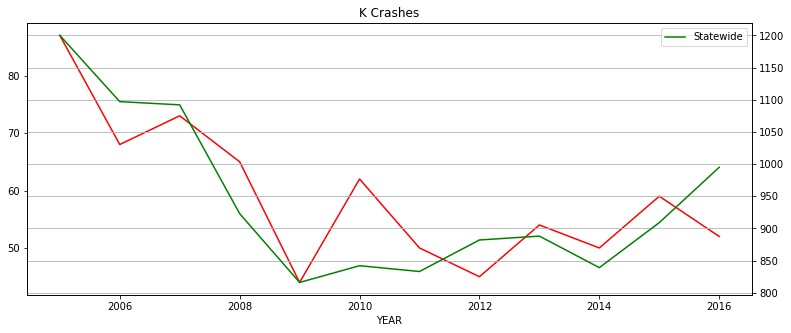

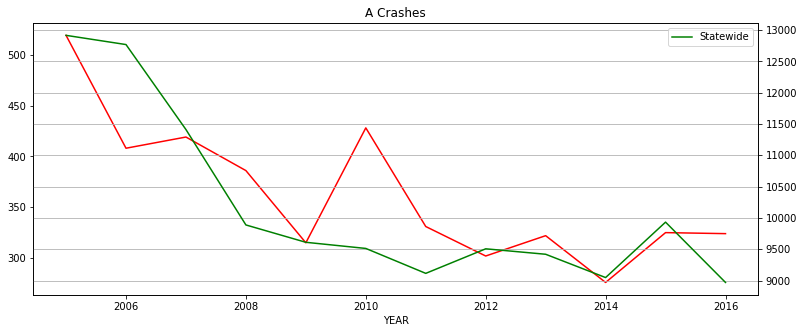

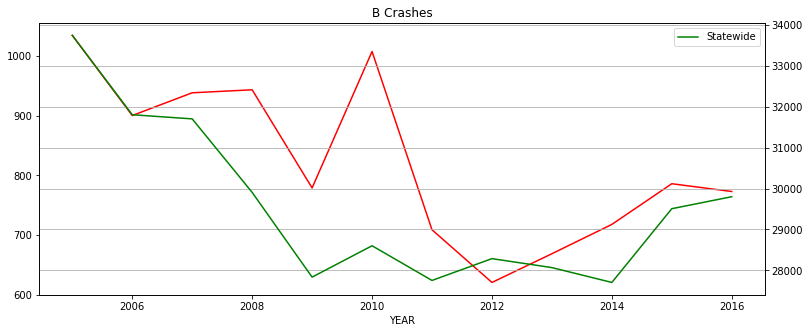

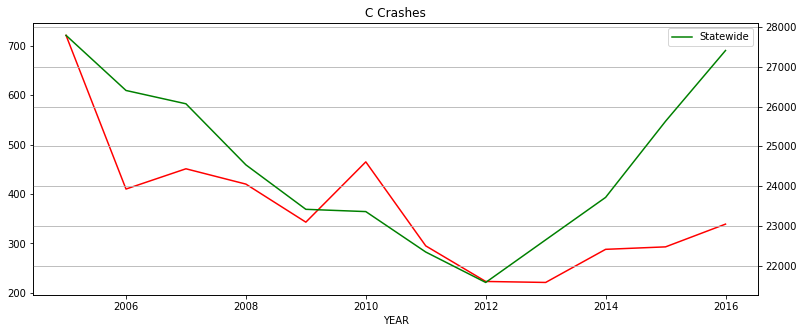

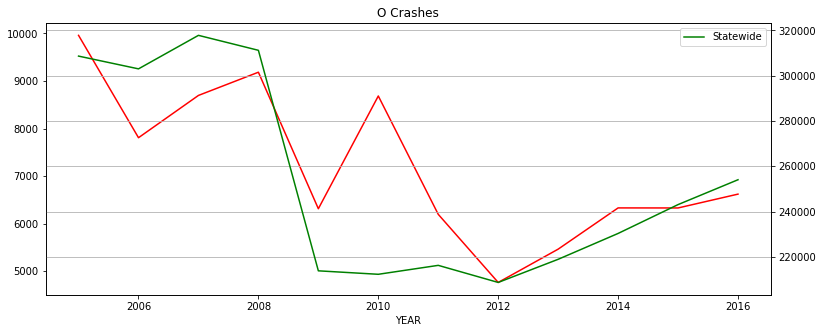

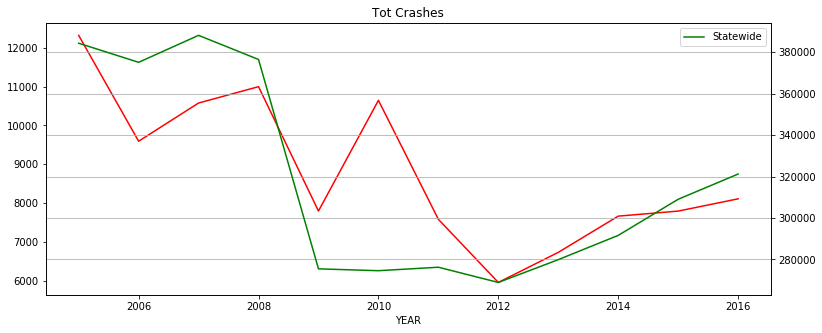

In [55]:
df['Tot'] = df.K+df.A+df.B+df.C+df.O 
for sev in ['K','A','B','C','O','Tot']:
    ax1 = df.groupby('YEAR')[sev].aggregate(sum).plot(label='Treated',color='red',figsize=(13,5))
    ax2 = ax1.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))
    if sev=='Tot':
        Crash_DF.groupby('YEAR').size().plot(ax=ax2,color='green',label='Statewide')
    else:
        Crash_DF[Crash_DF.KABCO==sev].groupby('YEAR').size().plot(ax=ax2,color='green',label='Statewide')
    plt.grid()
    plt.title('{} Crashes'.format(sev))
    plt.legend()
    plt.show()


In [64]:
for c in df1.columns:
    if hasattr(hsmpy3.il.domains,c):
        d = getattr(hsmpy3.il.domains,c)['codes']
        if len(d)>0:
            df1[c] = df1[c].apply(lambda x:d[x] if x in d.keys() else x)
df1

ContNum  YEAR        Period           CID  \
ContNum Period       CID                                                      
60D32   After        201001012089   60D32  2010         After  201001012089   
                     201001013329   60D32  2010         After  201001013329   
                     201001014515   60D32  2010         After  201001014515   
                     201001014670   60D32  2010         After  201001014670   
                     201001014734   60D32  2010         After  201001014734   
                     201001018368   60D32  2010         After  201001018368   
                     201001018399   60D32  2010         After  201001018399   
                     201001018548   60D32  2010         After  201001018548   
                     201001029233   60D32  2010         After  201001029233   
                     201001034754   60D32  2010         After  201001034754   
                     201001037276   60D32  2010         After  201001037276   
                     201001045970   60D32  2010         After  201001045970   
                     201001051462   60D32  2010         After  201001051462   
                     201001054396   60D32  2010         After  201001054396   
                     201001062578   60D32  2010         After  201001062578   
                     201001062578   60D32  2010         After  201001062578   
                     201001062578   60D32  2010         After  201001062578   
                     201001076432   60D32  2010         After  201001076432   
                     201001089732   60D32  2010         After  201001089732   
                     201001117372   60D32  2010         After  201001117372   
                     201001120107   60D32  2010         After  201001120107   
                     201001122366   60D32  2010         After  201001122366   
                     201001125910   60D32  2010         After  201001125910   
                     201001131143   60D32  2010         After  201001131143   
                     201001131941   60D32  2010         After  201001131941   
                     201001135296   60D32  2010         After  201001135296   
                     201001136881   60D32  2010         After  201001136881   
                     201001138387   60D32  2010         After  201001138387   
                     201001138387   60D32  2010         After  201001138387   
                     201001138387   60D32  2010         After  201001138387   
...                                   ...   ...           ...           ...   
99463   Construction 201101154647   99463  2011  Construction  201101154647   
                     201101185194   99463  2011  Construction  201101185194   
                     201101245399   99463  2011  Construction  201101245399   
                     201101373314   99463  2011  Construction  201101373314   
                     201101376937   99463  2011  Construction  201101376937   
                     201101384870   99463  2011  Construction  201101384870   
                     201101389131   99463  2011  Construction  201101389131   
                     201101425416   99463  2011  Construction  201101425416   
                     201101426744   99463  2011  Construction  201101426744   
                     201201097734   99463  2012  Construction  201201097734   
                     201201158119   99463  2012  Construction  201201158119   
99495   After        201501293273   99495  2015         After  201501293273   
                     201601167644   99495  2016         After  201601167644   
        Before       200503427332   99495  2005        Before  200503427332   
                     200503538906   99495  2005        Before  200503538906   
                     200504325212   99495  2005        Before  200504325212   
                     200602432125   99495  2006        Before  200602432125   
                     200604185739   99495  2006        Before  200604185739   
     

In [88]:
cdf = pd.DataFrame(df1.loc[cont].groupby(['Period','COL_TYPE','KABCO']).size())
cdf = cdf.unstack(level=[0,2])
cdf = cdf.T 
cdf.index = cdf.index.droplevel(0)
ct = list(hsmpy3.il.domains.COL_TYPE['codes'].values())
ct.sort()
cdf2 = pd.DataFrame(columns=ct,index = pd.MultiIndex.from_product([['Before','Construction','After'],['K','A','B','C','O']]))
cdf2 = cdf.loc[cdf2.index,cdf2.columns]
cdf2 = cdf2.fillna(0)
cdf2 = cdf2.astype(int)
cdf2

C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\ipykernel_launcher.py:1: FutureWarning: 'Period' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.
C:\Users\mr068144\AppData\Roaming\Python\Python35\site-packages\pandas\core\indexing.py:979: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_nested_tuple(tup)


Angle  Animal  Fixed object  Head-on  Other non-collision  \
Before       K      0       0             0        0                    0   
             A      0       0             1        0                    0   
             B      0       0             1        0                    0   
             C      0       0             0        0                    0   
             O      0       4             3        0                    0   
Construction K      0       0             0        0                    0   
             A      0       0             1        0                    0   
             B      0       0             0        0                    0   
             C      0       0             0        0                    0   
             O      0       0             1        0                    0   
After        K      0       0             0        0                    0   
             A      0       0             0        0                    0   
             B      0       0             0        0                    0   
             C      0       0             0        0                    0   
             O      0       2             2        0                    0   

                Other object  Overturned  Parked Motor vehicle  Pedalcyclist  \
Before       K             0           0                     0             0   
             A             0           1                     0             0   
             B             0           0                     0             0   
             C             0           0                     0             0   
             O             1           0                     0             0   
Construction K             0           0                     0             0   
             A             0           0                     0             0   
             B             0           0                     0             0   
             C             0           0                     0             0   
             O             0           0                     0             0   
After        K             0           0                     0             0   
             A             0           0                     0             0   
             B             0           0                     0             0   
             C             0           0                     0             0   
             O             0           0                     0             0   

                Pedestrian  Rear-end  Sideswipe-opposite direction  \
Before       K           0         0                             0   
             A           0         0                             0   
             B           0         0                             0   
             C           0         0                             0   
             O           0         0                             2   
Construction K           0         0                             0   
             A           0         0                             0   
             B           0         0                             0   
             C           0         0                             0   
             O           0         0                             0   
After        K           0         0                             0   
             A           0         0                             0   
             B           0         0                             0   
             C           0         0                             0   
             O           0         1                             0   

                Sideswipe-same direction  Train  Turning  
Before       K                         0      0        0  
             A                         0      0        0  
             B                         0      0        0  
             C                         0      0        0  
             O                         0      0        0  
Construction K             